In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind

# CD Data

In [3]:
CD_dir = '20240426_H2Db_CSM8_L11_melting_curves_CD'
V_cut = 700

names = {
    'no-pep':'Empty',
    'gp33':'gp33'
}

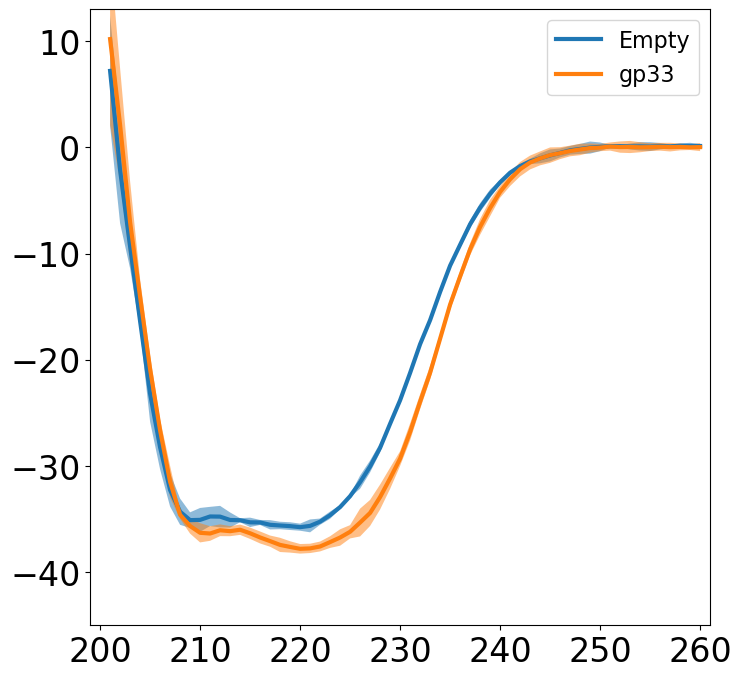

In [4]:
plt.figure(figsize=[8,8])

for pep in ['no-pep','gp33']:
    
    pooled_CD = []
    pooled_V = []
    
    for rep in range(1,4):
        data = pd.read_csv(f'{CD_dir}/initial/{pep}_{rep}.csv',skiprows=lambda x: (x<20) or (x>90),
                           names=['wavelength','CD','voltage'],dtype=float)
        
        pooled_CD.append(data['CD'].values)
        pooled_V.append(data['voltage'].values)
    
    pooled_CD = np.stack(pooled_CD,axis=0)
    pooled_V = np.stack(pooled_V,axis=0)
    
    pooled_CD[pooled_V > V_cut] = np.nan
    good_idx = np.all(pooled_V <= V_cut,axis=0)
    
    std = np.std(pooled_CD,axis=0)*2.58 #for 99% confidence interval
    avg = np.mean(pooled_CD,axis=0)
    
    plt.plot(data['wavelength'],avg,label=names[pep],linewidth=3)
    plt.fill_between(data['wavelength'],avg-std,avg+std,alpha=0.5)
    
plt.legend(loc='upper right',fontsize=16)
# plt.xlabel('Wavelength (nm)')
plt.xlim([199,261])
plt.ylim([-45,13])
# plt.ylabel('CD Signal')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig('CD_Initial_Spectra.png',dpi=300,bbox_inches='tight')

In [5]:
def tm_fit(T, slope, Tm, high, k, base):
    return high/(1 + np.exp(-k*(T-Tm))) + slope*(T) + base

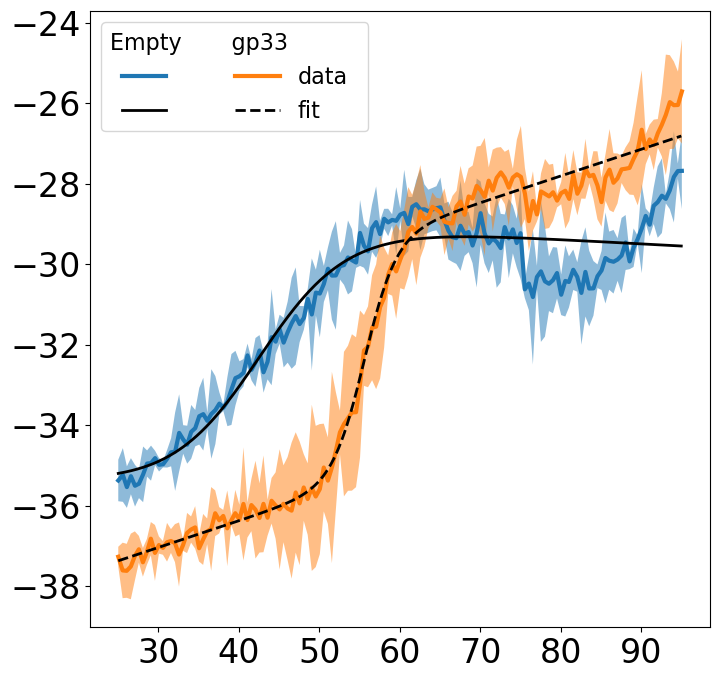

In [6]:
plt.figure(figsize=[8,8])
styles = ['-','--']

fit_labels = {
    'no-pep':' ',
    'gp33':'fit'
}
data_labels = {
    'no-pep':' ',
    'gp33':'data'
}

all_params = {}
for p,pep in enumerate(['no-pep','gp33']):
    
    pooled_CD = []
    pooled_V = []
    pooled_T = []
    
    for rep in range(1,4):
        data = pd.read_csv(f'{CD_dir}/melting/{pep}_{rep}.csv',skiprows=lambda x: (x<15) or (x>155),
                           names=['temp','CD','voltage'])
        
        pooled_CD.append(data['CD'].values)
        pooled_V.append(data['voltage'].values)
        pooled_T.append(data['temp'].values)
    
    pooled_CD = np.stack(pooled_CD,axis=0)
    pooled_V = np.stack(pooled_V,axis=0)
    pooled_T = np.stack(pooled_T,axis=0)
    
    pooled_CD[pooled_V > V_cut] = np.nan

    all_params[pep] = []
    for r in range(3):
        T = pooled_T[r,:]
        V = pooled_V[r,:]
        CD = pooled_CD[r,:]
        params,_ = curve_fit(lambda T,a,b,c,d,e: tm_fit(T, a, b, c, d, e),
                             T[V <= V_cut],
                             CD[V <= V_cut],
                             p0=[0,50,10,1,-40],
                             bounds=[[-np.inf, 25, 0,      0,      -np.inf],
                                     [np.inf,  95, np.inf, np.inf, np.inf]])
        all_params[pep].append(params)
    all_params[pep] = pd.DataFrame(data=all_params[pep],columns=['slope', 'Tm', 'high', 'k', 'base'])
    
    std = np.std(pooled_CD,axis=0)*2.58 #for 99% confidence interval
    avg = np.mean(pooled_CD,axis=0)
    
    plt.plot(data['temp'],avg,label=data_labels[pep],linewidth=3)
    plt.fill_between(data['temp'],avg-std,avg+std,alpha=0.5)

    x_fit = np.linspace(25,95,1000)
    y_fit = tm_fit(x_fit,*all_params[pep].mean(axis=0))
    plt.plot(x_fit,y_fit,'k',linewidth=2,linestyle=styles[p],label=fit_labels[pep])
    
plt.legend(loc='upper left',fontsize=16,ncol=2,title='Empty       gp33          ',title_fontsize=16)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
# plt.xlabel('Temp (C)')
# plt.ylabel('CD Signal')
plt.savefig('CD_melting_curves.png',dpi=300,bbox_inches='tight')

In [7]:
all_params['gp33'].mean(axis=0)

slope     0.066242
Tm       55.588965
high      5.916679
k         0.504555
base    -39.024112
dtype: float64

In [8]:
all_params['gp33'].std(axis=0)

slope    0.006726
Tm       0.837016
high     0.335426
k        0.027933
base     0.072575
dtype: float64

In [9]:
all_params['no-pep'].mean(axis=0)

slope    -0.010848
Tm       42.527928
high      6.669803
k         0.182627
base    -35.186204
dtype: float64

In [10]:
all_params['no-pep'].std(axis=0)

slope    0.005054
Tm       0.299838
high     0.421961
k        0.013575
base     0.060594
dtype: float64

# FP Data

In [12]:
cmap_tab = plt.get_cmap('tab10')
cmap_seq = plt.get_cmap('viridis')
cmap_blue = plt.get_cmap('Blues')

FP_dir = '../figure2_H2Db-characterization-xtal'

In [13]:
def eqm_binding(conc, K_D, high):
    return high*conc/(conc + K_D)

def eqm_binding_complex(conc_protein,conc_peptide,low,high,K_D):
    KDsum = conc_protein + conc_peptide + K_D
    f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)
    return low + f_bound*(high-low)

/var/folders/1r/_dnhk2ss6m3fr8s3lgl4kcmw0000gn/T/ipykernel_6422/1206017829.py:6: RuntimeWarning: invalid value encountered in sqrt
  f_bound = (KDsum - np.sqrt((KDsum)**2 - 4*conc_protein*conc_peptide))/(2*conc_peptide)


<Figure size 640x480 with 0 Axes>

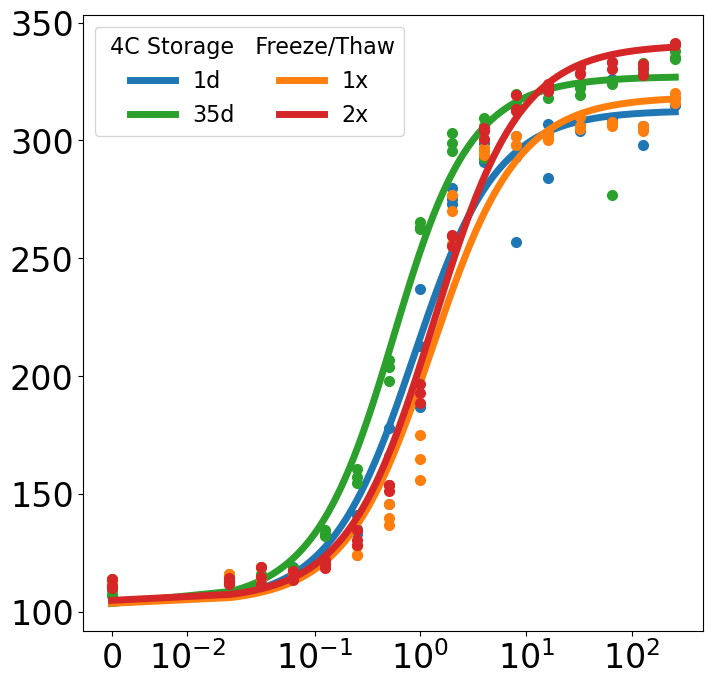

In [14]:
treated = {
    False:[0,1,2],
    True:[3,4,5],
}

concs = [256*(1/2)**i for i in range(15)] + [0]

plt.figure()

parallel = pd.read_csv(f'{FP_dir}/20240126_H2Db_L11_FP/parallel.csv',index_col=0,usecols=range(13))
parallel = np.concatenate([parallel.loc[:,'1':'6'].values,parallel.loc[:,'7':'12'].values],axis=0)

perpendicular = pd.read_csv(f'{FP_dir}/20240126_H2Db_L11_FP/perpendicular.csv',index_col=0,usecols=range(13))
perpendicular = np.concatenate([perpendicular.loc[:,'1':'6'].values,perpendicular.loc[:,'7':'12'].values],axis=0)

data_old = pd.read_csv(f'{FP_dir}/20231223_A02_and_H2Db_FP/H2Db_300pM.csv',index_col=0,usecols=range(13))
data_old = np.concatenate([data_old.loc[:,'1':'6'].values,data_old.loc[:,'7':'12'].values],axis=0)

parallel_mean = np.mean(parallel[-1,:])
perpendicular_mean = np.mean(perpendicular[-1,:])
polarization_mean = np.mean(data_old[-1,:])
G_factor = (parallel_mean*(1-(polarization_mean/1000)))/(perpendicular_mean*(1+(polarization_mean/1000)))

data_new = 1000*(parallel - G_factor*perpendicular)/(parallel + G_factor*perpendicular)

data = {
    'new': data_new,
    'old': data_old
}

types = {
    'new': {
        (0,1,2): '35d',
        (3,4,5): '2x'
    },
    
    'old': {
        (0,1,2): '1d',
        (3,4,5): '1x'
    }
}

all_params = {}
plt.figure(figsize=[8,8])
for c,cond in enumerate([(0,1,2),(3,4,5)]):
    for t,time in enumerate(['old','new']):        
        subset_data = data[time][:,cond]
        
        # if time == 'new':
        #     subset_data = subset_data + np.mean(data['old'][-1,:]) - np.mean(data['new'][-1,:])
        
        plt.plot(concs,subset_data,'o',markersize=7,color=cmap_tab(2*t + c))

        all_params[types[time][cond]] = []
        for r in range(3):
            params,_ = curve_fit(lambda x,a,b,c: eqm_binding_complex(x,0.3,a,b,c),
                                 concs,subset_data[:,r],p0=[80,250,concs[8]])
            all_params[types[time][cond]].append(params)
            
        all_params[types[time][cond]] = pd.DataFrame(data=all_params[types[time][cond]],columns=['low','high','K_D'])
        
        x_fit = np.concatenate([[0],
                            np.logspace(np.log10(0.5*concs[-2]),np.log10(concs[0]),1000)],axis=0)
        y_fit = eqm_binding_complex(x_fit,0.3,*all_params[types[time][cond]].mean(axis=0))
        plt.plot(x_fit,y_fit,'-',linewidth=5,color=cmap_tab(2*t + c),label=types[time][cond])
        
plt.xscale('symlog',linthresh=concs[-2])
plt.legend(loc='upper left',fontsize=16,ncols=2,title=' 4C Storage   Freeze/Thaw',title_fontsize=16)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.savefig(f'FP_curves.png',dpi=300,bbox_inches='tight')

1d 1.0
35d 0.07841547356393701
1x 0.03174974529086821
2x 0.031745233051659175


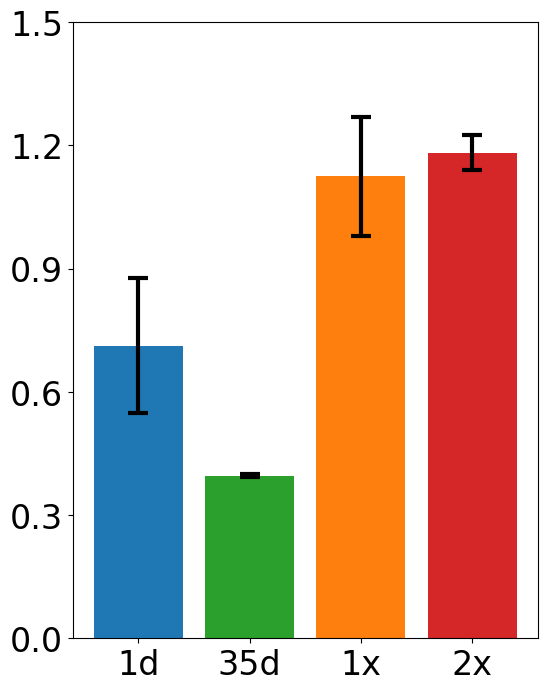

In [15]:
plt.figure(figsize=[6,8])
labels=[]
colors = [0,2,1,3]
for i,cond in enumerate(all_params):
    labels.append(cond)
    plt.bar(i,all_params[cond].mean(axis=0)['K_D'],
            yerr=all_params[cond].std(axis=0)['K_D'],
            color=plt.get_cmap('tab10')(colors[i]),
            capsize=7,
            error_kw={'elinewidth':3,
                      'capthick':3})
    p_val = ttest_ind(all_params[cond]['K_D'].values,
                      all_params['1d']['K_D'].values,
                      equal_var=False,
                      alternative='two-sided')
    print(cond,p_val.pvalue)
    # print(cond,all_params[cond].mean(axis=0)['K_D'],all_params[cond].std(axis=0)['K_D'])
plt.xticks(range(4),labels,fontsize=24)
plt.yticks([0,0.3,0.6,0.9,1.2,1.5],fontsize=24)
plt.savefig(f'FP_bar_plot.png',dpi=300,bbox_inches='tight')